In [ ]:
from keras import layers, models, callbacks
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models

import requests
from io import BytesIO

In [6]:
df = pd.read_csv('albums_genres_grouped.csv')

In [55]:
GENRE_KEYWORDS = [
    "pop", "rock", "rap", "hip hop", "trap", "country", "metal", "r&b", 
    "jazz", "indie", "electronic", "house", "techno", "reggae", "folk", 
    "funk", "soul", "punk", "blues", "alternative", "classical", "ambient", 
    "k-pop", "kids", "afrobeats","relaxed","latin"
]

# Mapping of leftover genre tags to canonical genres
MANUAL_GENRE_MAP = {
    # rock
    "psychedelic": "rock", "post-rock": "rock", "post-grunge": "rock", "grunge": "rock",
    "shoegaze": "rock", "canadian": "rock",

    # pop
    "female vocalist": "pop", "female vocalists": "pop", "5 seconds of summer": "pop",
    "synthpop": "pop", "tatemcrae": "pop", "my top songs": "pop", "sexy": "pop",
    "bee gees": "pop", "hyperpop": "pop", "digital tendencies": "pop", "2-step": "pop",
    "acoustic": "pop", "comedy": "pop", "singer-songwriter": "pop", "3": "pop",
    "disco": "pop", "wedding": "pop", "30": "pop", "peter": "pop", "midnights": "pop",
    "poptron": "pop", "doo-wop": "pop", "male vocals": "pop", "new wave": "pop",
    "later": "pop", "joaoaksnes": "pop", "madonna": "pop", "portals": "pop",
    "aoty": "pop", "mayhem": "pop", "guts": "pop", "short n' sweet": "pop",
    "soty": "pop", "cypriot": "pop", "breakbeat": "pop", "chinese": "pop",
    "german": "pop", "absolute bangers": "pop", "danish": "pop", "azerbaijan": "pop",
    "hardstyle": "pop", "japanese": "pop", "argentina": "pop", "indian": "pop",
    "india": "pop", "bhangra": "pop", "nigeria": "pop", "bollywood": "pop",
    "italian": "pop", "morocco": "pop", "traditional": "pop","ukrainian":"pop",

    # latin
    "puerto rico": "latin", "mexico": "latin", "sad sierreno": "latin",
    "lada del 602": "latin", "corridos tumbados": "latin", "seen live": "latin",
    "ramito de violeta": "latin", "chickencore": "latin", "corona": "latin",
    "cuck": "latin", "luar la l": "latin", "peso pluma": "latin", "spanish": "latin",
    "bachata": "latin", "salsa": "latin", "mierda": "latin", "banda": "latin",
    "duranguense": "latin", "romantico grupero": "latin", "colombia": "latin",
    "drum and bass": "latin", "sertanejo": "latin", "pagode": "latin", "samba": "latin","corrido tumbado":"latin","mexican":"latin","spain":"latin",

    # relaxed
    "ambient": "relaxed", "sleep": "relaxed", "reiki": "relaxed", "instrumental": "relaxed",
    "lo-fi": "relaxed", "rain": "relaxed", "nature sounds": "relaxed", "chill": "relaxed",
    "nature": "relaxed", "noise": "relaxed", "eargasm": "relaxed", "chillout": "relaxed",
    "white noise": "relaxed", "piano": "relaxed", "hindi": "relaxed","ambient":"relaxed",

    # rap
    "harder than diamonds": "rap", "peak": "rap", "drill": "rap", "heavy": "rap",
    "my scribbled": "rap", "drake": "rap", "baby keem": "rap", "g59": "rap", "j cole": "rap",
    "tag lil tecca-lot of me": "rap", "kanye wes": "rap", "bronx drill": "rap",
    "transitions": "rap", "auto-tagged": "rap", "gunna": "rap", "mumble crap": "rap",
    "boom bap": "rap", "quirky": "rap", "underrated": "rap", "phonk": "rap",
    "chipmunk soul": "rap", "diss": "rap", "worst album ever": "rap", "nitrous": "rap",
    "juggin": "rap", "4 out of 5": "rap", "czech": "rap",
    "sematary grave man from the haunted mound real nazgul skincarver keeper of da trees haunted mound lord": "rap",
    "grime": "rap","juice wrld":"rap","polo g":"rap","lil uzi vert":"rap","kanye west":"rap",

    # reggae
    "reggaeton": "reggae", "party": "reggae", "dancehall": "reggae", "love": "reggae",

    # hip hop
    "linedance": "hip hop", "nice": "hip hop", "florida": "hip hop", "don toliver": "hip hop",
    "southern hip-hop": "hip hop", "dr congo": "hip hop", "mother": "hip hop",
    "sampling": "hip hop", "plugg": "hip hop", "ebm": "hip hop", "egyptian": "hip hop",
    "a cappella": "hip hop", "ghana": "hip hop", "cumbia 420": "hip hop", "hip-hop": "hip hop","melodic hip-hop":"hip hop",

    # metal
    "metalcore": "metal", "progressive metalcore": "metal", "rage": "metal",
    "post-hardcore": "metal", "demonic": "metal",

    # r&b
    "rnb": "r&b", "aggressive": "r&b", "king billionheir": "r&b", "love at first listen": "r&b",
    "personal favourites": "r&b", "sza": "r&b", "british": "r&b", "3 out of 5": "r&b","steve lacy":"r&b",

    # k-pop
    "bts": "k-pop", "kpop": "k-pop", "korean": "k-pop", "jersey club": "k-pop", "it boy global": "k-pop",

    # religious
    "christian": "religious", "ccm": "religious", "worship": "religious", "gospel": "religious",
    "musiclist": "religious", "experimental": "religious", "hariharan": "religious", "thai": "religious",

    # electronic
    "depressive": "electronic", "indietronica": "electronic", "synthwave": "electronic",
    "childish gamblingo": "electronic", "featuring": "electronic", "trance": "electronic",
    "ass": "electronic", "downtempo": "electronic", "dance": "electronic", "60s": "electronic",
    "polish": "electronic", "russian": "electronic", "norway": "electronic", "eurodance": "electronic",
    "remix": "electronic", "frenchcore": "electronic", "uk garage": "electronic",

    # indie
    "songs i crank my hog to": "indie", "bossa nova": "indie", "wsum 91.7 fm madison": "indie",
    "songs i like to play whilst walking down the street at night music": "indie",
    "gambling addiction": "indie", "emo": "indie", "darkwave": "indie", "slowcore": "indie",
    "stolen": "indie", "life changing": "indie", "vinyl": "indie", "gothangelz": "indie",
    "ai": "indie", "ukranian": "indie", "opm": "indie",

    # afrobeats
    "afrobeats": "afrobeats", "kenyan": "afrobeats",

    # country
    "usa": "country", "fearless": "country", "linedance 2021": "country", "texas": "country",
    "feel good": "country", "furry": "country", "linedance catalan": "country", "american": "country", "haunted": "country","linedance 2022":"country",

    # kids
    "soundtrack": "kids", "video game music": "kids", "australian": "kids", "disney": "kids",
    "musical": "kids", "infantil": "kids",

    # trap
    "detroit trap": "trap",

    # funk
    "brazil": "funk",

    # folk
    "arabic": "folk"
}

def map_to_final_genre(genre_str):
    genre_str_lower = str(genre_str).strip().lower()
    
    # Check canonical match
    for genre in GENRE_KEYWORDS:
        if genre in genre_str_lower:
            return genre

    # Check exact match in manual mapping
    if genre_str_lower in MANUAL_GENRE_MAP:
        return MANUAL_GENRE_MAP[genre_str_lower]

    # Return as-is if not matched
    return genre_str_lower

# Apply to your DataFrame
df['genre_cleaned'] = df['genre'].apply(map_to_final_genre)


In [61]:
df["genre_cleaned"].unique()

array(['relaxed', 'folk', 'country', 'rap', 'pop', 'r&b', 'hip hop',
       'rock', 'indie', 'reggae', 'unknown', 'latin', 'electronic',
       'soul', 'metal', 'jazz', 'religious', 'k-pop', 'funk', 'kids'],
      dtype=object)

In [62]:
df = pd.read_csv("albums_genres_grouped.csv")
genre_map = {
    'hip hop': 'rap/hip hop',
    'rap': 'rap/hip hop',
    'soul': 'soul/jazz',
    'funk': 'soul/jazz',
    'jazz': 'soul/jazz',
    'folk': 'country/folk',
    'country': 'country/folk'
}

# Apply the mapping
df['genre_condensed'] = df['genre_cleaned'].replace(genre_map)
df.to_csv('albums_genres_grouped.csv', index=False)

In [ ]:
# Folder to save images
output_folder = "album_images"
os.makedirs(output_folder, exist_ok=True)

for index, row in df.iterrows():
    image_url = row['image_url']
    album_id = row['album_id']  # use this to uniquely name the image
    file_path = os.path.join(output_folder, f"{album_id}.jpg")

    try:
        response = requests.get(image_url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        img = img.convert("RGB")  # Make sure it's in a compatible format
        img.save(file_path, format='JPEG')
        print(f"Saved image for album: {row['album_name']}")
    except Exception as e:
        print(f"Failed to download image for {row['album_name']}: {e}")


Saved image for album: Best White Noise For Sleeping Baby
Saved image for album: folklore
Saved image for album: Starting Over
Saved image for album: Legends Never Die
Saved image for album: Whole Lotta Red
Saved image for album: After Hours
Saved image for album: songs
Saved image for album: SAVAGE MODE II
Saved image for album: Welcome to O'Block
Saved image for album: The Lo-Fis
Saved image for album: Kid Krow
Saved image for album: YHLQMDLG
Saved image for album: THE GOAT
Saved image for album: Dark Lane Demo Tapes
Saved image for album: Fuck The World
Saved image for album: The Slow Rush
Saved image for album: Levon James
Saved image for album: Eternal Atake
Saved image for album: My Turn
Saved image for album: Heaven Or Hell
Saved image for album: 528 Hz Meditation Music
Saved image for album: Dreamland
Saved image for album: Circles
Saved image for album: Stop Staring At the Shadows
Saved image for album: evermore
Saved image for album: Shoot For The Stars Aim For The Moon
Saved

In [ ]:
df = pd.read_csv("albums_genres_grouped.csv")

img_dir = "../album_images"
df['filepath'] = df['album_id'].apply(lambda x: os.path.join(img_dir, (x + '.jpg')))
df = df[df['filepath'].apply(os.path.exists)]  # Drop missing files

,album_id,album_name,artist_name,release_date,total_tracks,popularity,image_url,genre,genre_cleaned,filepath
0,0NGHR9zjS5eFFlqtClA9VV,Best White Noise For Sleeping Baby,Dream Supplier,2020-04-29,6,86,https://i.scdn.co/image/ab67616d0000b273f036cf...,ambient,relaxed,../album_images/0NGHR9zjS5eFFlqtClA9VV.jpg
1,2fenSS68JI1h4Fo296JfGr,folklore,Taylor Swift,2020-07-24,16,85,https://i.scdn.co/image/ab67616d0000b27395f754...,folk,folk,../album_images/2fenSS68JI1h4Fo296JfGr.jpg
2,0sOeI7pbAmIc8aDFyvkBUW,Starting Over,Chris Stapleton,2020-11-13,14,79,https://i.scdn.co/image/ab67616d0000b273940834...,country,country,../album_images/0sOeI7pbAmIc8aDFyvkBUW.jpg
3,6n9DKpOxwifT5hOXtgLZSL,Legends Never Die,Juice WRLD,2020-07-10,22,80,https://i.scdn.co/image/ab67616d0000b2733e0698...,juice wrld,rap,../album_images/6n9DKpOxwifT5hOXtgLZSL.jpg
4,2QRedhP5RmKJiJ1i8VgDGR,Whole Lotta Red,Playboi Carti,2020-12-25,24,81,https://i.scdn.co/image/ab67616d0000b27398ea0e...,trap,rap,../album_images/2QRedhP5RmKJiJ1i8VgDGR.jpg
...,...,...,...,...,...,...,...,...,...,...
1495,1FNlyaODRZdBnUIoApApdy,СПАСИ И ПОТУСИ,GSPD,2025-04-04,1,0,https://i.scdn.co/image/ab67616d0000b27387e426...,russian,electronic,../album_images/1FNlyaODRZdBnUIoApApdy.jpg
1496,3XlIAm2aT2MAfpmAuBjH5S,Intergalactic Dreams,Niphkeys,2025-04-03,8,0,https://i.scdn.co/image/ab67616d0000b273874637...,nigeria,pop,../album_images/3XlIAm2aT2MAfpmAuBjH5S.jpg
1497,5ESO6fmtHcFaKYDKuWurIu,Déjà-vu,GREGO,2025-04-04,1,0,https://i.scdn.co/image/ab67616d0000b2735ed640...,traditional,pop,../album_images/5ESO6fmtHcFaKYDKuWurIu.jpg
1498,1xpLTob6cmxhEAMalVmDCA,Ватсап (Remake 2025),VESNA305,2025-04-04,1,0,https://i.scdn.co/image/ab67616d0000b273751c57...,pop,pop,../album_images/1xpLTob6cmxhEAMalVmDCA.jpg


In [ ]:
# Setup
image_folder = "../album_images"
image_size = (64, 64)  # Or whatever your CNN input expects (e.g., 64x64)

# Choose the label column ('genre' or 'popularity')
label_column = 'popularity'  # or 'popularity'

# Filter for images that actually exist
df = pd.read_csv("albums_genres_grouped.csv")
df = df[df['album_id'].apply(lambda x: os.path.isfile(os.path.join(image_folder, f"{x}.jpg")))]

# Initialize lists
X = []
y = []

# Load and label
for _, row in df.iterrows():
    image_path = os.path.join(image_folder, f"{row['album_id']}.jpg")
    try:
        img = Image.open(image_path).resize(image_size)
        img_array = np.array(img) / 255.0  # Normalize to [0,1]
        X.append(img_array)
        y.append(row[label_column])
    except Exception as e:
        print(f"Error loading {image_path}: {e}")

X = np.array(X)
y = np.array(y)



In [ ]:
# Wrap into tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X, y))

# Shuffle, batch, prefetch
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Optional: split manually (or use sklearn's train_test_split earlier)
train_size = int(0.8 * len(X))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

train_dataset = (
    train_dataset
    .shuffle(buffer_size=1000)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_dataset = (
    val_dataset
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def preprocess(image, label):
    image = data_augmentation(image)
    return image, label

train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)


In [ ]:
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten + Dense
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))  # Single output for regression

callback = callbacks.EarlyStopping(monitor='loss', patience=1, verbose=1)

# Compile
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

model.fit(train_dataset, validation_data=val_dataset, epochs=20)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,273 (2.47 MB)

 Trainable params: 646,273 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 2107.1001 - mean_absolute_error: 39.4192 - val_loss: 5738.1685 - val_mean_absolute_error: 69.1249
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 207.1096 - mean_absolute_error: 11.5320 - val_loss: 4748.3110 - val_mean_absolute_error: 63.0212
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 108.3527 - mean_absolute_error: 8.1819 - val_loss: 4553.4985 - val_mean_absolute_error: 61.8305
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 81.3858 - mean_absolute_error: 7.1180 - val_loss: 4321.3936 - val_mean_absolute_error: 60.2920
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 68.9971 - mean_absolute_error: 6.5166 - val_loss: 4543.7783 - val_mean_absolute_error: 61.9172
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 64.1421 - mean_absolute_error: 6.3380 - val_loss: 4788.2734 - val_mean_absolute_error: 63.7941
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 79.8359 - m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


2025-04-16 13:24:54.708407: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


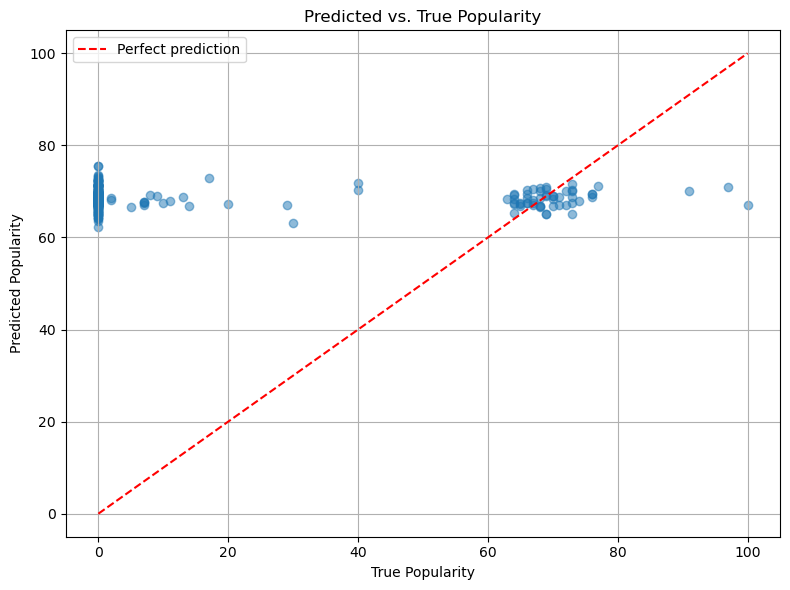

In [41]:
# Extract true labels and images from the validation dataset
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_pred.extend(preds.flatten())
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect prediction')
plt.xlabel("True Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Predicted vs. True Popularity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [63]:
# Setup
df = pd.read_csv("albums_genres_grouped.csv")
image_folder = "../album_images"
image_size = (64, 64)

le = LabelEncoder()
df['genre_cleaned_label'] = le.fit_transform(df['genre_cleaned'])
n_classes = len(le.classes_)

# Filter for images that actually exist
df = df[df['album_id'].apply(lambda x: os.path.isfile(os.path.join(image_folder, f"{x}.jpg")))]

# Initialize lists
X = []
y = []

# Load and label
for _, row in df.iterrows():
    image_path = os.path.join(image_folder, f"{row['album_id']}.jpg")
    try:
        img = Image.open(image_path).resize(image_size)
        img_array = np.array(img) / 255.0  # Normalize to [0,1]
        X.append(img_array)
        y.append(row['genre_cleaned_label'])
    except Exception as e:
        print(f"Error loading {image_path}: {e}")

X = np.array(X)
y = np.array(y)

In [66]:
# Split your data first (recommended)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# One-hot encode the labels (before creating the dataset)
y_train = to_categorical(y_train, num_classes=n_classes)
y_val = to_categorical(y_val, num_classes=n_classes)

# Wrap in tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Set batch size and autotune
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Optional data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Preprocessing function
def preprocess(image, label):
    image = data_augmentation(image)
    return image, label

# Apply augmentation only to training data
train_dataset = (
    train_dataset
    .shuffle(buffer_size=1000)
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_dataset = (
    val_dataset
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)


In [67]:

# CNN architecture (same structure, updated input/output)
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))  # Multi-class output

model.summary()

# Early stopping (optional)
callback = callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[callback]
)

/opt/anaconda3/envs/dsan6600/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,508 (2.47 MB)

 Trainable params: 647,508 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.1336 - loss: 2.8211 - val_accuracy: 0.1800 - val_loss: 2.6837
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1876 - loss: 2.6776 - val_accuracy: 0.1900 - val_loss: 2.6889
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1794 - loss: 2.6321 - val_accuracy: 0.2000 - val_loss: 2.6348
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1909 - loss: 2.6103 - val_accuracy: 0.2000 - val_loss: 2.6134
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1980 - loss: 2.6321 - val_accuracy: 0.2000 - val_loss: 2.6041
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1870 - loss: 2.6073 - val_accuracy: 0.2100 - val_loss: 2.6233
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1972 - loss: 2.6005 - val_accuracy: 0.1967 - val_loss: 2.5852
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2188 - loss: 2.5707 - val_accuracy: 0.2167 - v